In [424]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from htmresearch.support.gridcells.context_integration.context_layer import ContextLayer
from htmresearch.support.gridcells.context_integration.utils import (create_module_shape, 
                                                                     create_action_tensor, 
                                                                     get_actions, 
                                                                     get_3d_actions,
                                                                     get_closed_3d_path,
                                                                     load_digit_features)

from scipy.stats import entropy

%matplotlib inline
%load_ext autoreload
%autoreload 2



# m = 5   # Number of modules
# n = 23   # Approximate number of cells per module dimension
# d = 15   # Cells per minicolumn
# w = 10   # Code weight of the sensory SDR

FAC = 1

m = 8     # Number of modules
n = 30   # Approximate number of cells per module dimension
d = 20   # Cells per minicolumn
w = 5   # Code weight of the sensory SDR

zero = np.zeros(2*m)

# dx,dy,dz = get_actions(m,3)
dx,dy = get_actions(m,2)
dz = 2*dx + 9*dy



module_shapes = create_module_shape(m,n, rmin=-10,rmax=5)
action_tensor = create_action_tensor(m) 

X, V = get_closed_3d_path(num_samples=20, radius=5)

CL  = ContextLayer(layer_height=d, module_shapes=module_shapes, action_map=action_tensor, max_activity=200) 

F = load_digit_features(w=w, shape=CL.layer.shape)

print CL

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

**Context Layer:**
------------------
Number of cells:	 6640
Layer Shape:		 (20, 332)
Hyper-Module Shapes:
[[32 26]
 [26 28]
 [34 25]
 [33 27]
 [21 33]
 [31 25]
 [25 33]
 [32 22]]
Module bounds: [   0  832 1560 2410 3301 3994 4769 5594 6298]
Number of grid cells:	 6298
Activity bound:		 200
Action map shape:		 (8, 2, 16)
------------------


In [425]:
def top_k(score, k):
    return np.argsort(score)[::-1][:k]

def sparsify(arr, k):
    num_active = np.sum(arr!=0)
    k = min(k, num_active)
    arr_ = np.zeros(arr.shape).reshape(-1)
    sorted_args = np.argsort(arr.reshape(-1))[::-1]
    top_k = sorted_args[:k]
    arr_[top_k] = 1.
    return arr_.reshape(arr.shape)

def explode(CL, x, V):
    CL.clear()
    CL.add(x)
    x_ = sum([ CL.explore(v1*dx + v2*dy + v3*dz, mentally=True) for v1,v2,v3 in V])
    CL.clear()
    CL.add(x_)
    return CL.layer.copy()

def reassamble(CL, x, V):
    CL.clear()
    CL.add(x)
    x_ = sum([ CL.explore(-v1*dx - v2*dy - v3*dz, mentally=True) for v1,v2,v3 in V])
    CL.clear()
    CL.add(x_)
    return x_

def decode_landmark(x, k=1):
    score = np.sum(x, axis=0)
    return np.argsort(score)[::-1][:k]

def decode_landmark_as_state(x, k=1):
    s = np.zeros(x.shape)
    s[:, decode_landmark(x, k)] = 1.
    return s



**Context Layer:**
------------------
Number of cells:	 2440
Layer Shape:		 (20, 122)
Hyper-Module Shapes:
[[21 25]
 [24 17]
 [21 17]
 [21 24]
 [18 19]]
Module bounds: [   0  525  933 1290 1794 2136]
Number of grid cells:	 2136
Activity bound:		 520
Action map shape:		 (5, 2, 10)
------------------
400
0.25


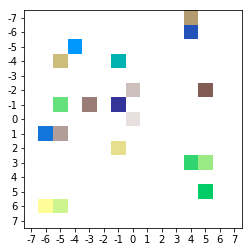

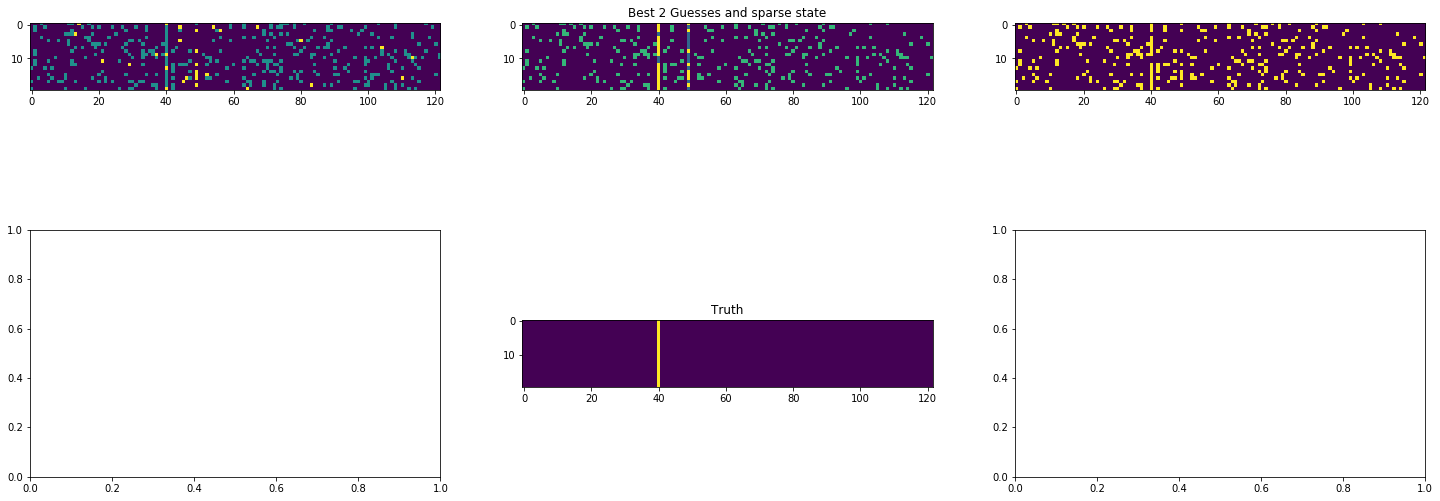

In [516]:
m = 5   # Number of modules
n = 20   # Approximate number of cells per module dimension
d = 20   # Cells per minicolumn
w = 1    # Code weight of the sensory SDR


dx,dy = get_actions(m,2)
module_shapes = create_module_shape(m, n, rmin=-6, rmax=6)
action_tensor = create_action_tensor(m) 
CL  = ContextLayer(layer_height=d, module_shapes=module_shapes, action_map=action_tensor, max_activity=520) 
print CL


radius = 7
env = np.zeros((2*radius+1,2*radius+1))

desired_activity = 3*d

num_landmarks = 20

print num_landmarks*d

# num_landmarks = min(20, CL.layer_shape[1])

L_ID  = np.arange(num_landmarks)
V = np.zeros((num_landmarks, 2*m)) 
V[:,:2]     = np.random.randint(-radius,radius, size=(num_landmarks,2))
V[0,:2 ]  = np.array([0.,0.]) 

PC_to_L = np.random.choice(CL.layer_shape[1], size=num_landmarks, replace=True)
PCBin   = np.zeros((num_landmarks, CL.layer_shape[0], CL.layer_shape[1]))
for i in range(num_landmarks):
    PCBin[i,:,PC_to_L[i]] = 1.0 



for t in range(num_landmarks):
    v = V[t]

    env[int(v[0]) + radius ,int(v[1]) + radius ] = t + 1

    CL.explore2(v)
    CL.add_to_counts(PCBin[t])
    CL.explore2(-v)



CL.sparsify(desired_activity)

count = 0
for t in range(num_landmarks):
    v = V[t]

    CL.explore2(v)
    state  = CL.layer_of_counts
    CL.explore2(-v)
    state_ = sparsify(state, desired_activity)
#     state_ = CL.layer
    
    truth = PC_to_L[t]
    guess = decode_landmark(state_, k=1)
    
    if truth in set(guess):
        count+=1

print float(count)/num_landmarks
    
    
t = 1
CL.explore2(V[t])
state  = CL.layer_of_counts
# state_ = sparsify(state,desired_activity)

state_ = CL.sparsify(desired_activity)
decoded_state = decode_landmark_as_state(state_, 2)
# decoded_state = decode_landmark_as_state(state, 2)
true_state = PCBin[t]
CL.explore2(-V[t])



plt.imshow(-env, cmap="terrain")
plt.xticks(range(2*radius+1), range(-radius, radius+1))
plt.yticks(range(2*radius+1), range(-radius, radius+1))
plt.show()


fig, ax = plt.subplots(2, 3, figsize=(25, 10));
ax[0,0].imshow(state)
ax[0,2].imshow(state_)
ax[0,1].set_title("Best 2 Guesses and sparse state")
ax[0,1].imshow(.5*decoded_state + 1.*state_)
ax[1,1].set_title("Truth")
ax[1,1].imshow(true_state)
plt.show()


